<a href="https://colab.research.google.com/github/ernesto-miguez/Machine-Learning-training/blob/master/Debugging_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Setup and loading data

In [1]:
% reset -f

# Load libraries
from os.path import join
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Set Pandas display options
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

wineDf = pd.read_csv(
  "https://download.mlcc.google.com/mledu-datasets/winequality.csv",
  encoding='latin-1')
wineDf.columns = ['fixed acidity','volatile acidity','citric acid',
                     'residual sugar','chlorides','free sulfur dioxide',
                     'total sulfur dioxide','density','pH',
                     'sulphates','alcohol','quality']
wineDf.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.3,0.4,20.7,0.0,45.0,170.0,1.0,3.0,0.5,8.8,6
1,6.3,0.3,0.3,1.6,0.0,14.0,132.0,1.0,3.3,0.5,9.5,6
2,8.1,0.3,0.4,6.9,0.1,30.0,97.0,1.0,3.3,0.4,10.1,6
3,7.2,0.2,0.3,8.5,0.1,47.0,186.0,1.0,3.2,0.4,9.9,6
4,7.2,0.2,0.3,8.5,0.1,47.0,186.0,1.0,3.2,0.4,9.9,6


## 2. Check correlation matrix

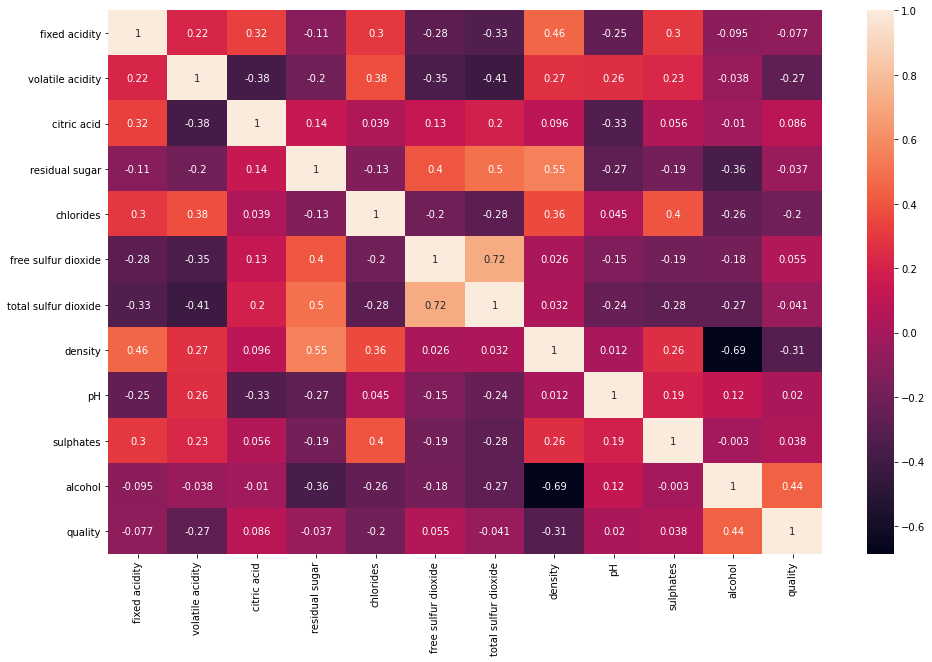

In [2]:
corr_wineDF = wineDf.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(corr_wineDF, annot=True)

## 3. Data Schema

In [0]:
def test_data_schema(input_data, schema):

  def test_dtypes():
    for column in schema.keys():
      assert input_data[column].map(type).eq(
          schema[column]['dtype']).all(), (
          "Incorrect dtype in column '%s'." % column
          )
    print ('Input dtypes are correct.')

  def test_ranges():
    for column in schema.keys():
      schema_max = schema[column]['range']['max']
      schema_min = schema[column]['range']['min']
      # Assert that data falls between schema min and max
      assert input_data[column].max() <= schema_max, (
          "Maximum value of column '%s' is too low." % column
      )
      assert input_data[column].min() >= schema_min, (
          "Minimum value of column '%s' is too high." % column
      )
    print('Data falls within specified ranges.')

  test_dtypes()
  test_ranges()

In [4]:
# Generate statistics to understand the statistical properties of your dataset
wineDf.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0
mean,7.2,0.3,0.3,5.4,0.1,30.5,115.7,1.0,3.2,0.5,10.5,5.8
std,1.3,0.2,0.1,4.8,0.0,17.7,56.5,0.0,0.2,0.1,1.2,0.9
min,3.8,0.1,0.0,0.6,0.0,1.0,6.0,1.0,2.7,0.2,8.0,3.0
25%,6.4,0.2,0.2,1.8,0.0,17.0,77.0,1.0,3.1,0.4,9.5,5.0
50%,7.0,0.3,0.3,3.0,0.0,29.0,118.0,1.0,3.2,0.5,10.3,6.0
75%,7.7,0.4,0.4,8.1,0.1,41.0,156.0,1.0,3.3,0.6,11.3,6.0
max,15.9,1.6,1.7,65.8,0.6,289.0,440.0,1.0,4.0,2.0,14.9,9.0


In [7]:
# Using max, min and data type values from the table above, for the first three columns (as a demonstration)
wine_schema = {
    'fixed acidity': {
        'range': {
            'min' : 3.8,
            'max' : 15.9
        },
        'dtype': float,
    },

    'volatile acidity': {
        'range': {
            'min' : 0.08,
            'max' : 1.6
        },
        'dtype' : float
    },

    'citric acid': {
        'range': {
            'min' : 0.0,
            'max' : 1.7
        },
        'dtype' : float
    }
}

print('Validating wine data against data schema...')
test_data_schema(wineDf, wine_schema)

Validating wine data against data schema...
Input dtypes are correct.
Data falls within specified ranges.


## 4. Split and Normalize Data

In [0]:
# Split the dataset into data and labels

wineFeatures = wineDf.copy(deep=True)
wineFeatures.drop(columns='quality', inplace=True)
wineLabels = wineDf['quality'].copy(deep=True)

In [0]:
# Normalize data using z-score
def normalizData(arr):
  stdArr = np.std(arr)
  meanArr = np.mean(arr)
  arr = (arr - meanArr)/ stdArr
  return arr

for str1 in wineFeatures.columns:
  wineFeatures[str1] = normalizData(wineFeatures[str1])

## 5. Test Engineered Data

In [0]:
# Set up testing functions

import unittest

def test_input_dim(df, n_rows, n_columns):
  assert len(df) == n_rows, "Unexpected number of rows"
  assert len(df.columns) == n_columns, "Unexpected number of columns"
  print("Egineered data has the expected number of rows and columns.")

def test_nulls(df):
  dataNulls = df.isnull().sum().sum()
  assert dataNulls == 0, "Nulls in engineered data."
  print("Engineered features do not contain nulls.")

In [21]:
# Test dimensions of engineered data 
test_input_dim(wineFeatures, 6497, 11)

# Test nulls of engineered data
test_nulls(wineFeatures)

Egineered data has the expected number of rows and columns.
Engineered features do not contain nulls.


## 6. Check Splits for Statistical Equivalence

In [29]:
splitIdx = int(wineFeatures.shape[0]*8/10)
wineFeatures.iloc[0:splitIdx,:].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0
mean,-0.2,-0.3,0.1,0.2,-0.2,0.2,0.3,-0.2,-0.1,-0.2,-0.0
std,0.7,0.8,0.9,1.1,0.9,1.0,0.8,1.0,1.0,0.9,1.0
min,-2.6,-1.6,-2.2,-1.0,-1.3,-1.6,-1.9,-2.5,-3.1,-2.1,-2.1
25%,-0.7,-0.8,-0.4,-0.8,-0.6,-0.5,-0.2,-1.0,-0.8,-0.8,-0.9
50%,-0.3,-0.4,-0.1,-0.1,-0.3,0.1,0.3,-0.2,-0.2,-0.3,-0.2
75%,0.1,0.0,0.5,0.9,-0.1,0.8,0.9,0.6,0.4,0.2,0.7
max,6.0,6.0,9.2,12.7,15.8,14.6,5.7,14.8,4.2,9.9,3.1


In [30]:
wineFeatures.iloc[splitIdx:-1,:].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0
mean,0.9,1.1,-0.3,-0.6,0.8,-0.8,-1.3,0.7,0.6,0.8,0.0
std,1.4,1.1,1.3,0.3,1.1,0.6,0.6,0.7,1.0,1.0,0.9
min,-1.8,-1.3,-2.2,-1.0,-1.3,-1.7,-1.9,-1.5,-2.2,-1.1,-1.8
25%,-0.1,0.3,-1.5,-0.7,0.4,-1.3,-1.7,0.3,-0.1,0.1,-0.7
50%,0.6,1.0,-0.3,-0.7,0.7,-0.9,-1.4,0.7,0.5,0.6,-0.1
75%,1.7,1.8,0.8,-0.6,1.0,-0.5,-1.0,1.1,1.1,1.3,0.7
max,6.7,7.5,3.2,2.1,10.4,2.3,3.1,3.0,4.9,7.3,3.7


### AS the two splits are clearly not equally representative, we are going to shuffle the data 

In [0]:
# Shuffle data
wineDf = wineDf.sample(frac=1).reset_index(drop=True)
# Recreate features and labels
wineFeatures = wineDf.copy(deep=True)
wineFeatures.drop(columns='quality', inplace=True)
wineLabels = wineDf['quality'].copy(deep=True)

In [32]:
splitIdx = int(wineFeatures.shape[0]*8/10)
wineFeatures.iloc[0:splitIdx,:].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0
mean,7.2,0.3,0.3,5.5,0.1,30.6,115.8,1.0,3.2,0.5,10.5
std,1.3,0.2,0.1,4.8,0.0,17.8,56.8,0.0,0.2,0.1,1.2
min,3.8,0.1,0.0,0.6,0.0,1.0,6.0,1.0,2.7,0.2,8.0
25%,6.4,0.2,0.2,1.8,0.0,17.0,77.0,1.0,3.1,0.4,9.5
50%,7.0,0.3,0.3,3.0,0.0,29.0,118.0,1.0,3.2,0.5,10.3
75%,7.7,0.4,0.4,8.1,0.1,42.0,156.0,1.0,3.3,0.6,11.3
max,15.9,1.6,1.7,65.8,0.6,289.0,440.0,1.0,4.0,2.0,14.9


In [33]:
wineFeatures.iloc[splitIdx:-1,:].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0
mean,7.2,0.3,0.3,5.3,0.1,30.3,115.3,1.0,3.2,0.5,10.5
std,1.2,0.2,0.1,4.7,0.0,17.5,55.2,0.0,0.2,0.2,1.2
min,3.9,0.1,0.0,0.8,0.0,1.0,6.0,1.0,2.8,0.2,8.0
25%,6.4,0.2,0.2,1.8,0.0,17.0,79.0,1.0,3.1,0.4,9.5
50%,7.0,0.3,0.3,2.9,0.0,29.0,118.0,1.0,3.2,0.5,10.3
75%,7.6,0.4,0.4,8.0,0.1,40.0,154.5,1.0,3.3,0.6,11.3
max,15.5,1.3,1.2,31.6,0.4,124.0,294.0,1.0,4.0,2.0,14.0


Now we can observe that the splits are equally representative.
It turns out that in the wine dataset, the first 4897 rows contain data on white wines and the next 1599 rows contain data on red wines. When you split your dataset 80:20, then your training dataset contains 5197 examples, which is 94% white wine. The validation dataset is purely red wine.

## 7. Establish a Baseline

For a regression problem, the simplest baseline to predict the average value. Calculate the mean-squared error (MSE) loss on the training split using the average value as a baseline. Our loss is approximately 0.75. Any model should beat this loss to justify its use.

In [34]:
baselineMSE = np.square(wineLabels[0:splitIdx]-np.mean(wineLabels[0:splitIdx]))
baselineMSE = np.sum(baselineMSE) / len(baselineMSE)
print(baselineMSE)

0.7639718582185537


## 8. Linear Model

Following good ML dev practice, let's start with a linear model that uses the most informative feature from the correlation matrix: `alcohol`. Even if this model performs badly, we can still use it as a baseline. This model should beat our previous baseline's MSE of 0.75.

In [0]:
def showRegressionResults(trainHistory):
  
  # Print final loss
  print("Final training loss: " + str(trainHistory.history['loss'][-1]))
  print("Final Validation loss: " + str(trainHistory.history['val_loss'][-1]))

  # Print loss curves
  plt.plot(trainHistory.history['loss'])
  plt.plot(trainHistory.history['val_loss'])
  plt.legend(['Training loss', 'Validation loss'], loc='best')
  plt.title('Loss Curves')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Final training loss: 5.171353340148926
Final Validation loss: 5.064475059509277


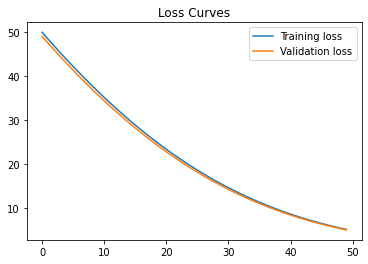

In [36]:
model = None 
wineFeaturesSimple = wineFeatures['alcohol']
# Define model
model = keras.Sequential()
model.add(keras.layers.Dense(units=1, activation='linear', input_dim=1))
# Specify the optimizer using TF API to specify learning rate
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.01), loss='mse')
# Train model
trainHistory = model.fit(wineFeaturesSimple,
                         wineLabels,
                         epochs=50,
                         batch_size=wineFeatures.shape[0],
                         validation_split=0.2,
                         verbose=0)
# Plot
showRegressionResults(trainHistory)

The loss decreases but very slowly. Possible fixes are:

* Increase number of epochs.
* Increase learning rate.
* Decrease batch size. A lower batch size can result in larger decrease in loss per epoch, under the assumption that the smaller batches stay representative of the overall data distribution.

Play with these three parameters in the code above to decrease the loss.

Final training loss: 0.6164828831928841
Final Validation loss: 0.6331181136461405


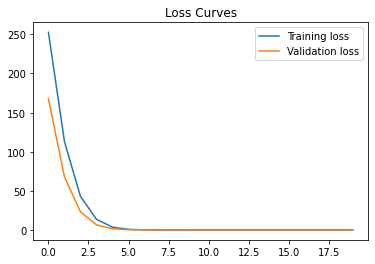

In [40]:
# We train the model again with a reduced batch size (100) and epochs = 20

model = None 
wineFeaturesSimple = wineFeatures['alcohol']
# Define model
model = keras.Sequential()
model.add(keras.layers.Dense(units=1, activation='linear', input_dim=1))
# Specify the optimizer using TF API to specify learning rate
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.01), loss='mse')
# Train model
trainHistory = model.fit(wineFeaturesSimple,
                         wineLabels,
                         epochs=20,
                         batch_size=100,
                         validation_split=0.2,
                         verbose=0)
# Plot
showRegressionResults(trainHistory)

 Reducing the batch size leads to a greater decrease in loss per epoch. The minimum achievable loss is about 0.64, which is a significant increase over our baseline of 0.75.

## 9. Add feature to Linear Model

Final training loss: 0.5752882109666435
Final Validation loss: 0.5746279198389787


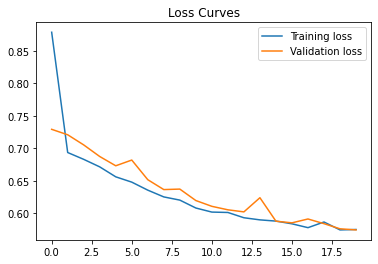

In [44]:
# Add 'volatile acidity'
model = None
wineFeaturesSimple = wineFeatures[['alcohol', 'volatile acidity']]
# Define model
model = keras.Sequential()
model.add(keras.layers.Dense(wineFeaturesSimple.shape[1],
                             input_dim=wineFeaturesSimple.shape[1],
                             activation='linear'))

model.add(keras.layers.Dense(1, activation='linear'))

# Compile
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.01), loss='mse')
# Train
trainHistory = model.fit(wineFeaturesSimple,
                         wineLabels,
                         epochs=20,
                         batch_size=100,
                         validation_split=0.2,
                         verbose=0)

# Plot the results
showRegressionResults(trainHistory)

The training loss has slightly decreased from 0.61 to 0.58

## 10. Use a Nonlinear Model

Final training loss: 0.6240348363693389
Final Validation loss: 0.6401957731980544


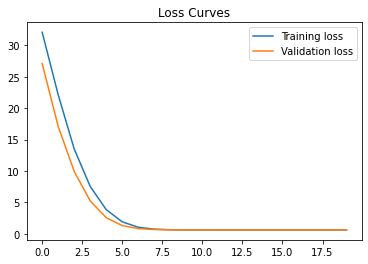

In [46]:
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(wineFeaturesSimple.shape[1],
                             input_dim=wineFeaturesSimple.shape[1],
                             activation='relu'))
model.add(keras.layers.Dense(1, activation='linear'))

# Compile
model.compile(optimizer=tf.train.AdamOptimizer(), loss='mse')
# Fit
trainHistory = model.fit(wineFeaturesSimple,
          wineLabels,
          epochs=20,
          batch_size=100,
          validation_split=0.2,
          verbose=0)
# Plot the results
showRegressionResults(trainHistory)

## 11. Optimize the model

Let's try optimize the model by:
- Adding the features chlorides and density
- Set training epochs to 200
- Set batch size to 100

Final training loss: 0.569448993094545
Final Validation loss: 0.5690958454058721


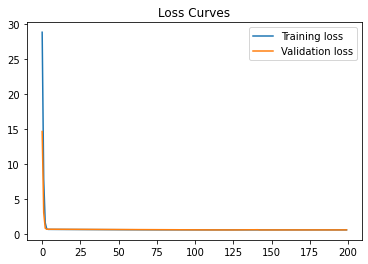

In [48]:
# Choose features
wineFeaturesSimple = wineFeatures[['alcohol', 'volatile acidity', 'chlorides', 'density']]
# Define
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(wineFeatures.shape[1],
                             activation = 'relu',
                             input_dim=wineFeaturesSimple.shape[1]))

# Add more layers
model.add(keras.layers.Dense(1, activation='linear'))
# Compile
model.compile(optimizer=tf.train.AdamOptimizer(), loss='mse')
# Train
trainHistory = model.fit(wineFeaturesSimple,
                         wineLabels,
                         epochs=200,
                         batch_size=100,
                         validation_split=0.2,
                         verbose=0)

# Plot the results
showRegressionResults(trainHistory)

The loss reduces to 0.56. It seems that adding more features or capacity isn't improving the model by much. Maybe it's because the model has a bug

## 12. Check for Implementation Bugs using Reduced Dataset

Final training loss: 0.2294718325138092


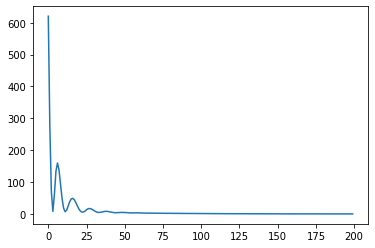

In [49]:
# Choose 10 examples
wineFeaturesSmall = wineFeatures[0:10]
wineLabelsSmall = wineLabels[0:10]
# Define model
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(wineFeaturesSmall.shape[1], activation='relu',
                             input_dim=wineFeaturesSmall.shape[1]))
model.add(keras.layers.Dense(wineFeaturesSmall.shape[1], activation='relu'))
model.add(keras.layers.Dense(1, activation='linear'))
# Compile
model.compile(optimizer=tf.train.AdamOptimizer(0.01), loss='mse') # set LR
# Train
trainHistory = model.fit(wineFeaturesSmall,
                        wineLabelsSmall,
                        epochs=200,
                        batch_size=10,
                        verbose=0)
# Plot results
print("Final training loss: " + str(trainHistory.history['loss'][-1]))
plt.plot(trainHistory.history['loss'])

## 13. Trying a very complex model

*   Using all the features
*   3 fully-connected relu layers + final layer




Train on 5197 samples, validate on 1300 samples
Epoch 1/100
5197/5197 [==============================] - 1s 127us/sample - loss: 190.2996 - val_loss: 10.8108
Epoch 2/100
5197/5197 [==============================] - 0s 25us/sample - loss: 8.2746 - val_loss: 6.6661
Epoch 3/100
5197/5197 [==============================] - 0s 23us/sample - loss: 6.6535 - val_loss: 5.8955
Epoch 4/100
5197/5197 [==============================] - 0s 26us/sample - loss: 5.9242 - val_loss: 5.2125
Epoch 5/100
5197/5197 [==============================] - 0s 23us/sample - loss: 5.2197 - val_loss: 4.5110
Epoch 6/100
5197/5197 [==============================] - 0s 26us/sample - loss: 4.4186 - val_loss: 3.6088
Epoch 7/100
5197/5197 [==============================] - 0s 23us/sample - loss: 3.0471 - val_loss: 2.1050
Epoch 8/100
5197/5197 [==============================] - 0s 26us/sample - loss: 1.7779 - val_loss: 1.4428
Epoch 9/100
5197/5197 [==============================] - 0s 23us/sample - loss: 1.2777 - val_loss: 1

(0.4, 1.0)

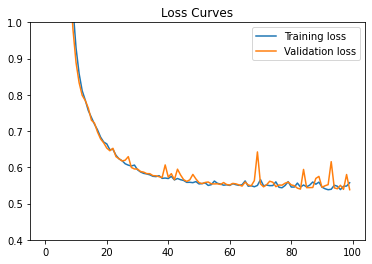

In [50]:
model=None
# Define
model = keras.Sequential()
model.add(keras.layers.Dense(wineFeatures.shape[1], activation='relu',
                             input_dim=wineFeatures.shape[1]))
model.add(keras.layers.Dense(wineFeatures.shape[1], activation='relu'))
model.add(keras.layers.Dense(wineFeatures.shape[1], activation='relu'))
model.add(keras.layers.Dense(1,activation='linear'))
# Compile
model.compile(optimizer=tf.train.AdamOptimizer(), loss='mse')
# Train the model
trainHistory = model.fit(wineFeatures, 
                         wineLabels, 
                         epochs=100,
                         batch_size=100,
                         validation_split=0.2,
                         verbose=1)

# Plot the results
showRegressionResults(trainHistory)
plt.ylim(0.4,1)

## Results

If you train for long enough, the minimum achievable MSE is around 0.52, which is a decrease of 0.04 from the previous best loss of 0.56. This decrease probably isn't worth the performance and complexity cost of using all your features and a deeper network. However, that decision depends on the objectives you're optimizing for.

If you train the model long enough, the validation loss actually starts increasing while training loss continues to decrease. This divergence in loss curves means your model is overfitting. The overfitting results from the closer fit that your very complex model can learn. Stick with the simpler model. You'll be happier and live longer!

If you do want to optimize your loss, then play with the model to find the minimum achievable training loss before overfitting sets in. Try playing with the network parameters in the code cell above to achieve a loss of 0.51. But be warned—optimizing your loss could take a lot of trial and error..